# DNN Fashion MNIST

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [2]:
# Image Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# train(학습용) 데이터셋 로드
train_data = datasets.FashionMNIST(root='data',
                                   train=True,        # 학습용 데이터셋 설정(True)
                                   download=True,
                                   transform=transform
                                  )
# test(학습용) 데이터셋 로드
test_data = datasets.FashionMNIST(root='data',
                                  train=False,        # 검증용 데이터셋 설정(False)
                                  download=True,
                                  transform=transform
                                 )

100%|██████████| 26421880/26421880 [00:01<00:00, 18994057.27it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300137.91it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5439075.80it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5835750.54it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



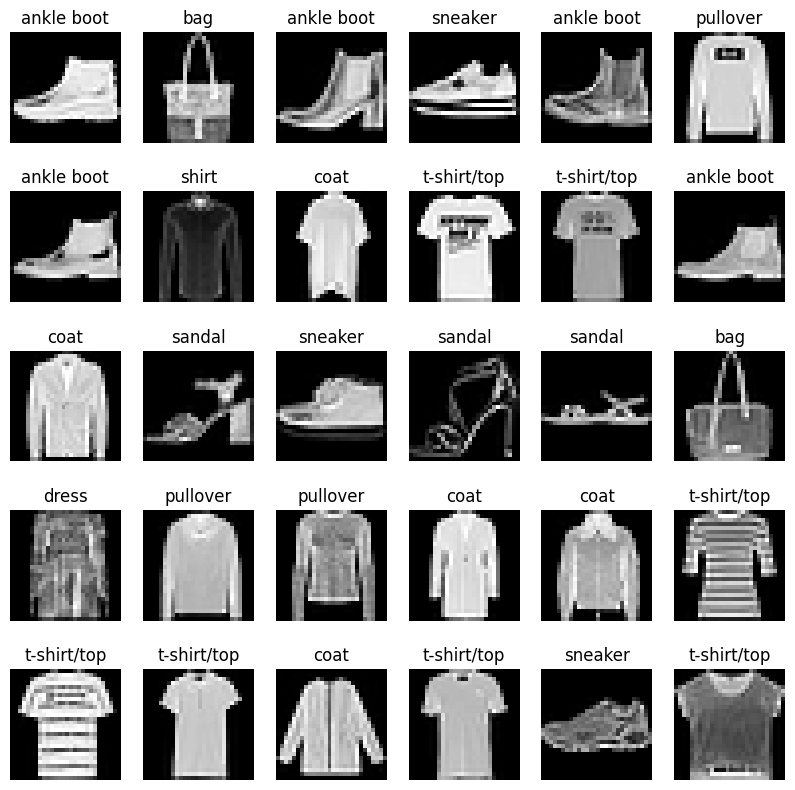

In [4]:
import matplotlib.pyplot as plt

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

In [5]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# 1개의 배치 추출 후 Image, label의 shape 출력
img, lbl = next(iter(train_loader))
img.shape, lbl.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [8]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x

In [10]:
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

DNNModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [11]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [12]:
from tqdm import tqdm  # Progress Bar 출력

In [13]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)

        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)

        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)

        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()

        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [14]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()

    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()

            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [15]:
# 최대 Epoch을 지정합니다.
num_epochs = 20

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 1875/1875 [00:29<00:00, 62.59it/s] 


[INFO] val_loss has been improved from inf to 0.46023. Saving Model!
epoch 01, loss: 0.54103, acc: 0.80630, val_loss: 0.46023, val_accuracy: 0.83290


100%|██████████| 1875/1875 [00:24<00:00, 77.41it/s]


[INFO] val_loss has been improved from 0.46023 to 0.39591. Saving Model!
epoch 02, loss: 0.37902, acc: 0.86233, val_loss: 0.39591, val_accuracy: 0.85460


100%|██████████| 1875/1875 [00:22<00:00, 81.70it/s]


[INFO] val_loss has been improved from 0.39591 to 0.38943. Saving Model!
epoch 03, loss: 0.33648, acc: 0.87683, val_loss: 0.38943, val_accuracy: 0.86180


100%|██████████| 1875/1875 [00:23<00:00, 80.58it/s]


[INFO] val_loss has been improved from 0.38943 to 0.34449. Saving Model!
epoch 04, loss: 0.31048, acc: 0.88593, val_loss: 0.34449, val_accuracy: 0.87530


100%|██████████| 1875/1875 [00:25<00:00, 72.90it/s]


[INFO] val_loss has been improved from 0.34449 to 0.33911. Saving Model!
epoch 05, loss: 0.29180, acc: 0.89165, val_loss: 0.33911, val_accuracy: 0.87830


100%|██████████| 1875/1875 [00:24<00:00, 75.14it/s]


epoch 06, loss: 0.27701, acc: 0.89618, val_loss: 0.35214, val_accuracy: 0.87430


100%|██████████| 1875/1875 [00:25<00:00, 73.31it/s]


epoch 07, loss: 0.26130, acc: 0.90252, val_loss: 0.36713, val_accuracy: 0.86910


100%|██████████| 1875/1875 [00:30<00:00, 61.55it/s]


[INFO] val_loss has been improved from 0.33911 to 0.32587. Saving Model!
epoch 08, loss: 0.24792, acc: 0.90738, val_loss: 0.32587, val_accuracy: 0.88390


100%|██████████| 1875/1875 [00:22<00:00, 81.75it/s]


[INFO] val_loss has been improved from 0.32587 to 0.31650. Saving Model!
epoch 09, loss: 0.23665, acc: 0.91090, val_loss: 0.31650, val_accuracy: 0.88430


100%|██████████| 1875/1875 [00:24<00:00, 77.53it/s]


epoch 10, loss: 0.22573, acc: 0.91475, val_loss: 0.32784, val_accuracy: 0.88380


100%|██████████| 1875/1875 [00:26<00:00, 70.01it/s]


epoch 11, loss: 0.21727, acc: 0.91852, val_loss: 0.32348, val_accuracy: 0.88490


100%|██████████| 1875/1875 [00:24<00:00, 75.77it/s]


epoch 12, loss: 0.20767, acc: 0.92195, val_loss: 0.33257, val_accuracy: 0.88170


100%|██████████| 1875/1875 [00:25<00:00, 73.47it/s]


epoch 13, loss: 0.20082, acc: 0.92368, val_loss: 0.31923, val_accuracy: 0.89410


100%|██████████| 1875/1875 [00:26<00:00, 71.63it/s]


[INFO] val_loss has been improved from 0.31650 to 0.30844. Saving Model!
epoch 14, loss: 0.19375, acc: 0.92593, val_loss: 0.30844, val_accuracy: 0.89360


100%|██████████| 1875/1875 [00:26<00:00, 69.97it/s]


epoch 15, loss: 0.18439, acc: 0.93068, val_loss: 0.32672, val_accuracy: 0.89120


100%|██████████| 1875/1875 [00:26<00:00, 70.28it/s]


epoch 16, loss: 0.17829, acc: 0.93222, val_loss: 0.33780, val_accuracy: 0.88780


100%|██████████| 1875/1875 [00:25<00:00, 73.20it/s]


epoch 17, loss: 0.17322, acc: 0.93390, val_loss: 0.32629, val_accuracy: 0.89410


100%|██████████| 1875/1875 [00:25<00:00, 73.61it/s]


epoch 18, loss: 0.16551, acc: 0.93733, val_loss: 0.33375, val_accuracy: 0.89350


100%|██████████| 1875/1875 [00:25<00:00, 72.26it/s]


epoch 19, loss: 0.15815, acc: 0.93983, val_loss: 0.36504, val_accuracy: 0.89070


100%|██████████| 1875/1875 [00:24<00:00, 75.28it/s]


epoch 20, loss: 0.15639, acc: 0.94055, val_loss: 0.35680, val_accuracy: 0.89150


In [16]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

<All keys matched successfully>

In [17]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.30844, evaluation accuracy: 0.89360
